<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/Notebooks/BAF_Exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [1]:
#!git clone https://github.com/MDankloff/Cluster-Bias-Disco.git
#!cd Cluster-Bias-Disco/
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF'

Mounted at /content/drive


In [2]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.3 MB/s eta 0:00:00


In [3]:
import pickle
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import glob
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score

# Load data and Best LightGBM Models

Sets of features (data columns)

In [4]:
#MASTER DATASET

META = ['clusters', 'new_clusters']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = ['payment_type', 'days_since_request', 'bank_branch_count_8w', 'credit_risk_score', 'source', 'device_os', 'device_fraud_count','month', 'session_length_in_minutes',
       'velocity_6h', 'velocity_24h', 'velocity_4w', 'email_is_free', 'proposed_credit_limit', 'keep_alive_session'] #, 'intended_balcon_amount']
SEN = ['customer_age', 'income', 'employment_status'] #protected attributes in BAF paper
PROX = ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'zip_count_4w', 'date_of_birth_distinct_emails_4w',
        'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'foreign_request',
        'device_distinct_emails']

################################## SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['payment_type_scaled', 'days_since_request_scaled', 'bank_branch_count_8w_scaled', 'credit_risk_score_scaled',
              'source_scaled', 'device_os_scaled', 'device_fraud_count_scaled','month_scaled', 'session_length_in_minutes_scaled',
              'velocity_6h_scaled', 'velocity_24h_scaled', 'velocity_4w_scaled', 'email_is_free_scaled', 'proposed_credit_limit_scaled', 'keep_alive_session_scaled'] #, 'intended_balcon_amount_scaled']
SEN_scaled = ['customer_age_scaled', 'income_scaled', 'employment_status_scaled']
PROX_scaled = [['name_email_similarity_scaled', 'prev_address_months_count_scaled', 'current_address_months_count_scaled', 'zip_count_4w_scaled',
                'date_of_birth_distinct_emails_4w_scaled','housing_status_scaled', 'phone_home_valid_scaled', 'phone_mobile_valid_scaled',
                'bank_months_count_scaled', 'has_other_cards_scaled', 'foreign_request_scaled', 'device_distinct_emails_scaled']]

'''Removed features:
'''

'Removed features:\n'

load data from parquet files

In [5]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


In [6]:
#Rename datasets
base = dataframes['Base']
variant1 = dataframes['Variant I']
variant2 = dataframes['Variant II']
variant3 = dataframes['Variant III']
variant4 = dataframes['Variant IV']
variant5 = dataframes['Variant V']

In [7]:
#remove features
features_to_remove = ['intended_balcon_amount', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'email_is_free', 'proposed_credit_limit', 'keep_alive_session']

for df_name, df in dataframes.items():
  for column in features_to_remove:
    if column in df.columns:
      df.drop(column, axis=1, inplace=True)


In [8]:
variant1.iloc[500]

,500
fraud_bool,0
income,0.3
name_email_similarity,0.128825
prev_address_months_count,-1
current_address_months_count,77
customer_age,20
days_since_request,0.008666
payment_type,AB
zip_count_4w,3565
bank_branch_count_8w,13


In [9]:
# directory containing the model files
model_dir = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant'

# Get list of all model files in the directory
model_files = glob.glob(os.path.join(model_dir, '*.pkl'))

# Dictionary to store loaded models
models = {}

# Load all models from the directory and save them to the dictionary
for model_file in model_files:
    # Load the model
    with open(model_file, 'rb') as f:
        model = joblib.load(f)

    # Extract the model name from the file path (without extension)
    model_name = os.path.basename(model_file).split('.')[0]

    # Add the model to the dictionary
    models[model_name] = model

    # Optional: Save the model back (though it seems redundant here)
    save_path = os.path.join(model_dir, f'{model_name}.pkl')
    joblib.dump(model, save_path)

    print(f"Model '{model_name}' loaded and saved to: {save_path}")

# Accessing the best model per variant
modelb = models.get("model_Base_top_4")
modelv1 = models.get("model_Variant I_top_4")
modelv2 = models.get("model_Variant II_top_4")
modelv3 = models.get("model_Variant III_top_0")
modelv4 = models.get("model_Variant IV_top_6")
modelv5 = models.get("model_Variant V_top_0")

# Pre-process

In [10]:
#base.head()

In [11]:
base['payment_type']

,payment_type
0,AA
1,AD
2,AB
3,AB
4,AA
...,...
999995,AB
999996,AC
999997,AA
999998,AB


In [12]:
train_dfs = {key: df[df["month"] < 6].sample(frac=1, replace=False) for key, df in dataframes.items()}
test_dfs = {key: df[df["month"] >= 6].sample(frac=1, replace=False) for key, df in dataframes.items()}

In [13]:
def convert_object_to_num(data):
    for column in data.select_dtypes(include=['object']).columns:
        # Convert object to boolean if the values are binary (0/1)
        if data[column].isin([0, 1]).all():  # Checks if the column contains only 0s and 1s
            data[column] = data[column].astype(bool)  # Convert to boolean (True/False)

        # Otherwise, convert to numeric (int or float)
        else:
            try:
                data[column] = pd.to_numeric(data[column], errors='raise', downcast='integer')
            except ValueError:
                # If conversion fails to int, try float
                try:
                    data[column] = pd.to_numeric(data[column], errors='raise', downcast='float')
                except ValueError:
                    # If numeric conversion fails, coerce errors to NaN (handle invalid strings)
                    data[column] = pd.to_numeric(data[column], errors='coerce')
    return data

In [14]:
base_df_cleaned = convert_object_to_num(test_dfs['Base'])
variant1_df_cleaned = convert_object_to_num(test_dfs['Variant I'])
variant2_df_cleaned = convert_object_to_num(test_dfs['Variant II'])
variant3_df_cleaned = convert_object_to_num(test_dfs['Variant III'])
variant4_df_cleaned = convert_object_to_num(test_dfs['Variant IV'])
variant5_df_cleaned = convert_object_to_num(test_dfs['Variant V'])
base_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205011 entries, 945059 to 896191
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        205011 non-null  int64  
 1   income                            205011 non-null  float64
 2   name_email_similarity             205011 non-null  float64
 3   prev_address_months_count         205011 non-null  int64  
 4   current_address_months_count      205011 non-null  int64  
 5   customer_age                      205011 non-null  int64  
 6   days_since_request                205011 non-null  float64
 7   payment_type                      0 non-null       float64
 8   zip_count_4w                      205011 non-null  int64  
 9   bank_branch_count_8w              205011 non-null  int64  
 10  date_of_birth_distinct_emails_4w  205011 non-null  int64  
 11  employment_status                 0 non-null       f

In [33]:
variant3['customer_age'].value_counts()

,count
customer_age,
30,311433
20,245855
40,238712
50,140353
60,34770
10,20987
70,6517
80,1297
90,76


In [34]:
#base['customer_age'].value_counts() #same as variant3

,count
customer_age,
30,311433
20,245855
40,238712
50,140353
60,34770
10,20987
70,6517
80,1297
90,76


In [35]:
variant1['customer_age'].value_counts()

,count
customer_age,
30,337975
20,268243
40,260103
50,86053
10,22980
60,20031
70,3809
80,751
90,55


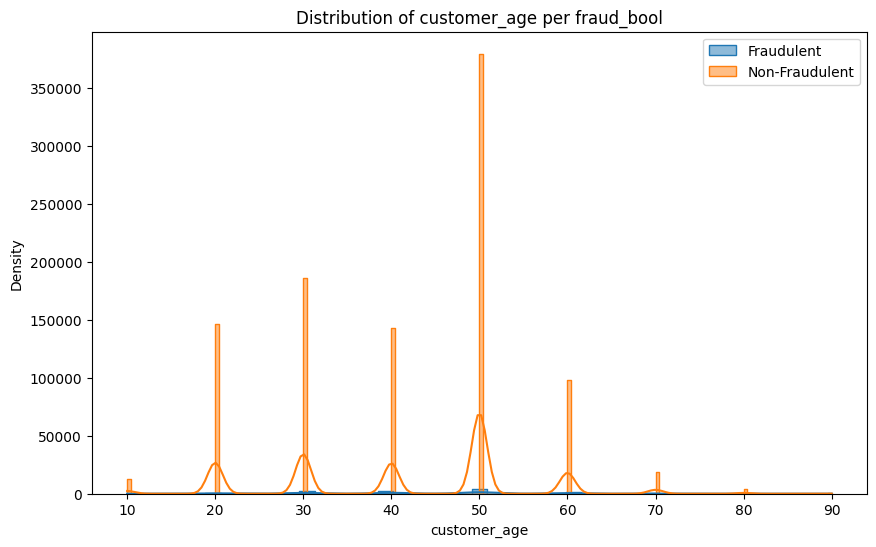

In [32]:
fraud_age = variant3.loc[variant3['fraud_bool'] == 1, 'customer_age']
nonfraud_age = variant3.loc[variant3['fraud_bool'] == 0]['customer_age']

plt.figure(figsize=(10, 6))
sns.histplot(fraud_age, kde=True, label='Fraudulent', element='step')
sns.histplot(nonfraud_age, kde=True, label='Non-Fraudulent', element='step')


plt.title('Distribution of customer_age per fraud_bool')
plt.xlabel('customer_age')
plt.ylabel('Density')
plt.legend()
plt.show()

In [29]:
variant3['income'].value_counts()

,count
income,
0.9,241062
0.8,151514
0.1,145056
0.6,110152
0.7,104981
0.4,78410
0.2,64963
0.5,55077
0.3,48785


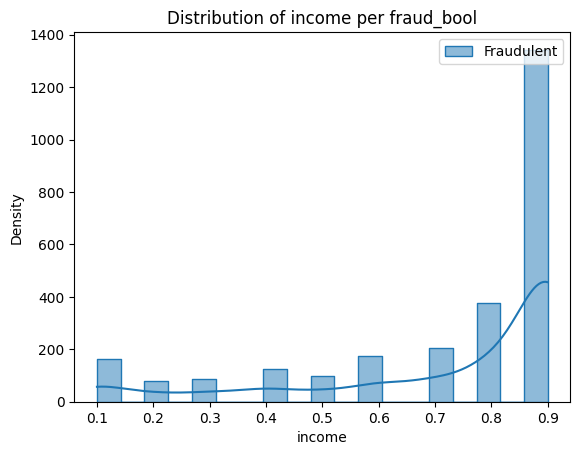

In [23]:
fraud_income = variant3_df_cleaned.loc[variant3_df_cleaned['fraud_bool'] == 1, 'income']
nonfraud_income = variant3_df_cleaned.loc[variant3_df_cleaned['fraud_bool'] == 0]['income']

plt.figure(figsize=(10, 6))
sns.histplot(fraud_income, kde=True, label='Fraudulent', element='step')
sns.histplot()

plt.title('Distribution of income per fraud_bool')
plt.xlabel('income')
plt.ylabel('Density')
plt.legend()
plt.show()

In [28]:
variant3['employment_status'].value_counts()

,count
employment_status,
CA,684981
CB,135133
CC,89089
CF,44943
CD,26648
CE,18719
CG,487


# Get the Errors

In [15]:
def get_errors (model, data, test_dfs):
    """
    Evaluate trained model on test data and compute metrics and errors.
    - model: Trained model (Best LightGBM model)
    - X_test: Feature matrix for the test data
    - Y_test: True labels for the test data

    Returns:
    - metrics: Dictionary containing calculated metrics (accuracy, precision, recall, f1, ROC AUC)
    - predictions: DataFrame containing the true and predicted classes along with errors
    """

    #get train and test data
    X_train = train_dfs[data].drop(columns=["fraud_bool"])
    Y_train = train_dfs[data]["fraud_bool"]
    X_test = test_dfs[data].drop(columns=["fraud_bool"])
    Y_test = test_dfs[data]["fraud_bool"]

    #predict
    Y_pred = model.predict(X_test)
    Y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC AUC (for class 1)

    # Convert predictions and true labels to integers if they are not already
    Y_pred = Y_pred.astype(int)  # Ensure predictions are integers (0 or 1)
    Y_test = Y_test.astype(int)  # Ensure true labels are integers (0 or 1)

   #get evaluation metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='binary')
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_prob)

    #Print the evaluation metrics & confusion matrix
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Create predictions DataFrame
    predictions = pd.DataFrame({
        'predicted_class': Y_pred,
        'true_class': Y_test,
        'errors': abs(Y_pred - Y_test)
    }, index=X_test.index)

    # Merge predictions with the original test data
    test_dfs[data] = pd.merge(test_dfs[data], predictions, left_index=True, right_index=True, how='outer')


    return {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc
    }, predictions

In [16]:
test_dfs['Base']

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,payment_type,zip_count_4w,bank_branch_count_8w,...,phone_mobile_valid,bank_months_count,has_other_cards,foreign_request,source,session_length_in_minutes,device_os,device_distinct_emails_8w,device_fraud_count,month
945059,0,0.9,0.874791,-1,23,30,0.007198,NaN,2808,0,...,1,-1,0,0,NaN,4.552691,NaN,1,0,7
973195,0,0.9,0.581379,86,7,40,8.002318,NaN,456,7,...,1,1,0,0,NaN,11.583921,NaN,1,0,7
978338,0,0.4,0.612246,36,5,30,0.005841,NaN,843,773,...,1,11,0,0,NaN,4.560332,NaN,1,0,7
878108,0,0.9,0.889206,-1,23,50,0.008753,NaN,847,18,...,1,1,0,0,NaN,17.433037,NaN,1,0,6
851700,0,0.8,0.827929,-1,138,50,0.014355,NaN,696,18,...,1,26,1,0,NaN,4.235359,NaN,1,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923637,0,0.9,0.896691,-1,42,20,0.014315,NaN,843,15,...,1,10,0,0,NaN,2.352453,NaN,1,0,7
878666,0,0.1,0.155662,-1,201,70,0.023449,NaN,1540,27,...,1,1,1,0,NaN,8.497805,NaN,1,0,6
909426,0,0.4,0.161355,-1,47,30,0.027890,NaN,3245,14,...,1,30,0,0,NaN,3.215854,NaN,1,0,7
980987,0,0.9,0.880493,29,7,50,0.010002,NaN,606,10,...,1,-1,1,0,NaN,15.119242,NaN,1,0,7


Add the metrics and errors to all variants

In [17]:
base_metrics, base_error = get_errors(modelb, 'Base', test_dfs)
v1_metrics, v1_error = get_errors(modelv1, 'Variant I', test_dfs)
v2_metrics, v2_error = get_errors(modelv2, 'Variant II', test_dfs)
v3_metrics, v3_error = get_errors(modelv3, 'Variant III', test_dfs)
v4_metrics, v4_error = get_errors(modelv4, 'Variant IV', test_dfs)
v5_metrics, v5_error = get_errors(modelv5, 'Variant V', test_dfs)


#print(test_dfs['Base'].head())  # Includes original columns + true_class, predicted_class, errors
#print(test_dfs['Variant I'].head())  # Includes the same for 'Variant I'

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
# Rename updated datasets to new variables
Base_error = test_dfs['Base']
V1_error = test_dfs['Variant I']
V2_error = test_dfs['Variant II']
V3_error = test_dfs['Variant III']
V4_error = test_dfs['Variant IV']
V5_error = test_dfs['Variant V']

# Get the error labels

In [ ]:
def add_error_labels(df):
    df['TP'] = ((df['true_class'] == 1) & (df['predicted_class'] == 1)).astype(int)
    df['TN'] = ((df['true_class'] == 0) & (df['predicted_class'] == 0)).astype(int)
    df['FN'] = ((df['true_class'] == 1) & (df['predicted_class'] == 0)).astype(int)
    df['FP'] = ((df['true_class'] == 0) & (df['predicted_class'] == 1)).astype(int)
    return df

# Apply the function to each error dataset
Base_error = add_error_labels(Base_error)
V1_error = add_error_labels(V1_error)
V2_error = add_error_labels(V2_error)
V3_error = add_error_labels(V3_error)
V4_error = add_error_labels(V4_error)
V5_error = add_error_labels(V5_error)

In [ ]:
Base_error.head()
#Base_error.iloc[500]

In [ ]:
#Check if there are any FP/FN
#Base_error[Base_error['FN']==1]

# Add SHAP values on testset

In [ ]:
!pip install shap
import shap

 TreeExplainer is specifically optimized for tree-based models such as LightGBM, XGBoost, and CatBoost.

In [ ]:
X_train = (train_dfs[Base_error].drop(columns=["fraud_bool"]))


explainer = shap.TreeExplainer(modelb, X_train)